In [0]:
import copy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device type:', device)

Device type: cuda


# Neural Style Transfer

**Common scheme of the method:**

![](https://sunshineatnoon.github.io/assets/posts/2017-05-19-a-brief-summary-on-neural-style-transfer/FeedForward.png)

Let be:

- $\vec{x}$ - input (likely random) image vector;

- $\vec{p}$ - content image (photograph) vector;

- $\vec{a}$ - style image (atrwork) vector.

Then **total** loss function is:

$$\mathcal{L_{total}}(\vec{p}, \vec{a}, \vec{x}) = \alpha \mathcal{L_c}(\vec{p}, \vec{x}) + \beta \mathcal{L_s}(\vec{a}, \vec{x})$$

**Content** and **style** loss functions are defined as follows:

$$\mathcal{L_c}(\vec{p}, \vec{x}, l) = \frac{1}{2} \sum_{ij}(F^l_{ij} - P^l_{ij})^2$$

$$\mathcal{L_s}(\vec{a}, \vec{x}, l) = \frac{\omega_l}{N} \sum_{ij}(G^l_{ij} - A^l_{ij})^2$$

Where:

* $F^l_{ij}$ and $P^l_{ij}$ are activations of $i^{th}$ filter at positon $j$ in layer $l$ of input and content images respectively;

* $G^l_{ij}$ and $A^l_{ij}$ are Gram matrixes of input and style images respectively:

$$G^l_{ij} = \sum_{k} F^l_{ik} F^l_{jk}$$

* $F^l_{ik}$ is a vectorizer feature map in layer $l$ of $i^{th}$ filter at $k^{th}$ position.

In [0]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, input_tensor):
        self.loss = F.mse_loss(input_tensor, self.target)
        return input_tensor

In [0]:
def gram_matrix(input_tensor):
    a, b, c, d = input_tensor.size()            # a=batch_size=1
    features = input_tensor.view(a * b, c * d)  # reshape to feature vector
    g_matrix = torch.mm(features, features.T)
    return g_matrix.div(a * b * c * d)

In [0]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.gram_target = gram_matrix(target)

    def forward(self, input_tensor):
        input_gram = gram_matrix(input_tensor)
        self.loss = F.mse_loss(input_gram, self.gram_target)
        return input_tensor

## Model building

In [0]:
# create a module to normalize input image
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        # make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img,
                               content_layers=content_layers_default, style_layers=style_layers_default):
    
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # add content loss
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # add style loss
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model)-1,-1,-1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:i + 1]

    return model, style_losses, content_losses

In [0]:
def get_input_optimizer(input_img):
    # input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):

    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, 
                                                                     normalization_mean,
                                                                     normalization_std,
                                                                     style_img,
                                                                     content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Download feature extraction part of vgg19:

In [0]:
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

Model architecture:

In [11]:
vgg19

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [12]:
i = 0
for name, layer in vgg19.named_children() :
    if isinstance(layer, nn.Conv2d):
        print(layer, i)
        i += 1

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 0
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 1
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 2
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 3
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 4
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 5
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 6
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 7
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 8
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 9
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 10
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 11
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 12
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 13
Conv2d(512, 512, kerne

## Reproduce already solved problem

Download files:

In [13]:
!wget "https://upload.wikimedia.org/wikipedia/commons/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg" -O "content_neckarfront.jpg"
!wget "https://media.overstockart.com/optimized/cache/data/product_images/VG485-1000x1000.jpg" -O "style_starrynight.jpg"
!wget "https://www.howardshollow.com/canvascolor/IMAGES/MODERNIST/B/50a.jpg" -O "style_shipwreck.jpg"

--2020-06-15 19:50:27--  https://upload.wikimedia.org/wikipedia/commons/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4976410 (4.7M) [image/jpeg]
Saving to: ‘content_neckarfront.jpg’

content_neckarfront 100%[===================>]   4.75M  27.8MB/s    in 0.2s    

2020-06-15 19:50:27 (27.8 MB/s) - ‘content_neckarfront.jpg’ saved [4976410/4976410]

--2020-06-15 19:50:28--  https://media.overstockart.com/optimized/cache/data/product_images/VG485-1000x1000.jpg
Resolving media.overstockart.com (media.overstockart.com)... 104.108.163.127
Connecting to media.overstockart.com (media.overstockart.com)|104.108.163.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235722 (230K) [image/jpeg]
Saving to: ‘style_starrynight.jpg’

style_s

In [14]:
# check the files
!ls

content_neckarfront.jpg  style_shipwreck.jpg
sample_data		 style_starrynight.jpg


In [0]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

imsize = 512
loader = transforms.Compose([
                             transforms.Resize(imsize),
                             transforms.CenterCrop(imsize),
                             transforms.ToTensor()
                             ])

In [0]:
style_img = image_loader("style_starrynight.jpg")
style_img1 = image_loader("style_shipwreck.jpg")
content_img = image_loader("content_neckarfront.jpg")

In [17]:
# check shapes
style_img.shape, style_img1.shape, content_img.shape

(torch.Size([1, 3, 512, 512]),
 torch.Size([1, 3, 512, 512]),
 torch.Size([1, 3, 512, 512]))

Plot the images:

In [0]:
unloader = transforms.ToPILImage()

def imshow(tensor, ax=None, title=None):
    """
    Plot image pytorch tensor.
    """
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    
    if ax:
        ax.imshow(image)
        ax.set_title(title)
    else:
        plt.imshow(image)
        plt.title(title)

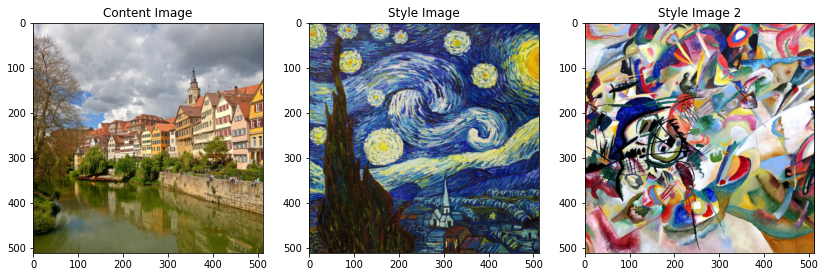

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(14, 10))

imshow(content_img, axes[0], title='Content Image')
imshow(style_img, axes[1], title='Style Image')
imshow(style_img1, axes[2], title='Style Image 2')

Run NST:

In [58]:
input_img = content_img.clone()
output = run_style_transfer(vgg19, 
                            cnn_normalization_mean, 
                            cnn_normalization_std,
                            content_img, 
                            style_img1, 
                            input_img, 
                            style_weight=1e6, 
                            content_weight=5)

Building the style transfer model...
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


run [50]:
Style Loss : 143.746704 Content Loss: 105.324738

run [100]:
Style Loss : 37.237034 Content Loss: 94.411507

run [150]:
Style Loss : 20.146698 Content Loss: 82.932510

run [200]:
Style Loss : 13.264085 Content Loss: 77.409676

run [250]:
Style Loss : 9.764969 Content Loss: 74.614037

run [300]:
Style Loss : 8.058949 Content Loss: 72.860344



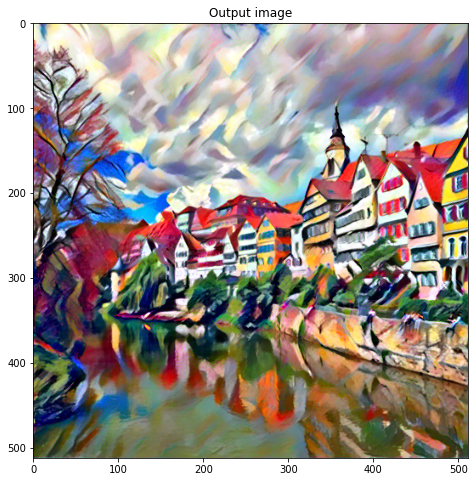

In [59]:
plt.figure(figsize=(8, 8))
imshow(output, title='Output image')

## My task

This part solves the task of transfer two image styles to a content image.

I define style loss as follows:

$$\mathcal{L_s}(\vec{a_1}, \vec{a_2}, \vec{x}, l) = \frac{\omega_1}{N} \sum_{ij}(G^l_{ij} - A^l_{1ij})^2 + \frac{\omega_2}{N} \sum_{ij}(G^l_{ij} - A^l_{2ij})^2$$

Where:

* $G^l_{ij}$, $A^l_{1ij}$, $A^l_{2ij}$ are Gram matrixes of input and two style images respectively;

* $\omega_1$ and $\omega_2$ are contribution coefficients of the style images.

In [0]:
class DoubleStyleLoss(nn.Module):
    """
    This loss function can aggregate more than two styles.
    """
    def __init__(self, target_batch):
        super().__init__()
        self.target_grams = []
        for target in target_batch:
            self.target_grams.append(gram_matrix(target.unsqueeze(0)))

        self.loss = torch.zeros(target_batch.shape[0])

    def forward(self, input_tensor):
        if input_tensor.shape[0] != 1:
            pass
        else:
            self.loss = []
            gram = gram_matrix(input_tensor)
            for target_gram in self.target_grams:
                self.loss.append(F.mse_loss(gram, target_gram))
        
        return input_tensor

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses1(cnn, normalization_mean, normalization_std, style_img, content_img,
                                content_layers=content_layers_default, style_layers=style_layers_default):
    """
    style_img -- batch of two (or several) style images.
    """
    
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # add content loss
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # add style loss
        if name in style_layers:
            target_feature = model(style_img).detach()      # batch of size 2
            style_loss = DoubleStyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model)-1,-1,-1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], DoubleStyleLoss):
            break

    model = model[:i + 1]

    return model, style_losses, content_losses

In [0]:
def run_style_transfer1(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1, s1_weight=0.5, s2_weight=0.5):

    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses1(cnn, 
                                                                      normalization_mean,
                                                                      normalization_std,
                                                                      style_img,
                                                                      content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += s1_weight * sl.loss[0] + s2_weight * sl.loss[1]

            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [0]:
style_batch = torch.cat([style_img, style_img1])

In [41]:
input_img = content_img.clone()
output1 = run_style_transfer1(vgg19, 
                              cnn_normalization_mean, 
                              cnn_normalization_std,
                              content_img, 
                              style_batch, 
                              input_img, 
                              s1_weight=0.55,
                              s2_weight=0.45)

Building the style transfer model...
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Using a target size (torch.Size([1, 128, 256, 256])) that is different to the input size (torch.Size([2, 128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  import sys


run [50]:
Style Loss : 3183.453857 Content Loss: 40.217613

run [100]:
Style Loss : 3034.814209 Content Loss: 37.889618

run [150]:
Style Loss : 2999.213867 Content Loss: 34.053043

run [200]:
Style Loss : 2987.028564 Content Loss: 29.896317

run [250]:
Style Loss : 2980.638184 Content Loss: 25.968523

run [300]:
Style Loss : 2976.926025 Content Loss: 22.899704



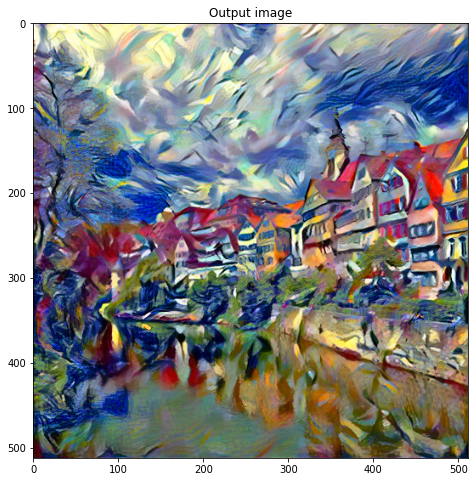

In [42]:
plt.figure(figsize=(8, 8))
imshow(output1, title='Output image')

**The result** strongly dependent on hyperparameres such as weights of content and styles and number of iterations.

Another method of style aggregation:

$$\mathcal{L_s}(\vec{a_1}, \vec{a_2}, \vec{x}, l) = \frac{1}{N} \sum_{ij} \left (G^l_{ij} - \left [\omega_1 A^l_{1ij} + \omega_2 A^l_{2ij} \right] \right)^2$$

Here notation is the same.

In [0]:
class DoubleStyleLoss2(nn.Module):
    """
    Another method of style aggregating.
    """
    def __init__(self, target_batch, style_weights=[0.5, 0.5]):
        super().__init__()
        self.target_gram = 0
        for target, weight in zip(target_batch, style_weights):
            self.target_gram += weight * gram_matrix(target.unsqueeze(0))

        self.loss = F.mse_loss(self.target_gram, self.target_gram)

    def forward(self, input_tensor):
        if input_tensor.shape[0] != 1:
            pass
        else:
            gram = gram_matrix(input_tensor)
            self.loss = F.mse_loss(gram, self.target_gram)
        
        return input_tensor



# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses2(cnn, normalization_mean, normalization_std, style_img, content_img,
                               content_layers=content_layers_default, style_layers=style_layers_default):
    """
    style_img -- batch of two style images.
    """
    
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # add content loss
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # add style loss
        if name in style_layers:
            target_feature = model(style_img).detach()      # batch of size 2
            style_loss = DoubleStyleLoss2(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model)-1,-1,-1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], DoubleStyleLoss):
            break

    model = model[:i + 1]

    return model, style_losses, content_losses



def run_style_transfer2(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=300,
                        style_weight=1000000, content_weight=1):

    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses2(cnn, 
                                                                     normalization_mean,
                                                                     normalization_std,
                                                                     style_img,
                                                                     content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss

            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [52]:
input_img = content_img.clone()
output2 = run_style_transfer2(vgg19, 
                              cnn_normalization_mean, 
                              cnn_normalization_std,
                              content_img, 
                              style_batch, 
                              input_img, 
                              num_steps=800)

Building the style transfer model...
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Using a target size (torch.Size([1, 128, 256, 256])) that is different to the input size (torch.Size([2, 128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  import sys


run [50]:
Style Loss : 9.136986 Content Loss: 12.528036

run [100]:
Style Loss : 2.089809 Content Loss: 9.348722

run [150]:
Style Loss : 1.058726 Content Loss: 8.377249

run [200]:
Style Loss : 0.829258 Content Loss: 7.953956

run [250]:
Style Loss : 0.775972 Content Loss: 7.668502

run [300]:
Style Loss : 0.848505 Content Loss: 7.734228

run [350]:
Style Loss : 3168845.750000 Content Loss: 297.635773

run [400]:
Style Loss : 16126747.000000 Content Loss: 524.213867

run [450]:
Style Loss : 13842093.000000 Content Loss: 412.368591

run [500]:
Style Loss : 83.443817 Content Loss: 50.065880

run [550]:
Style Loss : 17.492815 Content Loss: 33.570030

run [600]:
Style Loss : 8.721746 Content Loss: 23.997414

run [650]:
Style Loss : 4.901162 Content Loss: 19.052794

run [700]:
Style Loss : 2.489087 Content Loss: 16.210648

run [750]:
Style Loss : 1.873674 Content Loss: 14.207544

run [800]:
Style Loss : 1.419829 Content Loss: 12.640654



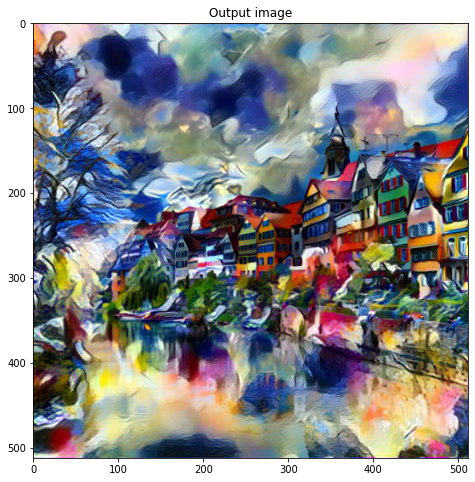

In [53]:
plt.figure(figsize=(8, 8))
imshow(output2, title='Output image')

**The result** is more empressive but training is unstable: need carefull set up number of iterations.

Other approaches (cGAN, cycle GAN) require much more computational power that i dont have and im so lazy...